### **Imports and Config**

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import time
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from dataclasses import dataclass
from fvcore.nn import FlopCountAnalysis
from torch.optim.lr_scheduler import ReduceLROnPlateau
import wandb

%matplotlib inline

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@dataclass
class Config:
    batch_size: int = 64
    learning_rate: float = 0.002
    epochs: int = 50
    patience: int = 8
    num_workers: int = 10
    rotation: int = 5
    translation: float = 0.1
    shear_angle: int = 1

# Initialize wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="mnist",
    # Track hyperparameters and run metadata
    config={
        "batch_size": Config.batch_size,
        "learning_rate": Config.learning_rate,
        "epochs": Config.epochs,
        "patience": Config.patience,
        "num_workers": Config.num_workers,
        "rotation": Config.rotation,
        "translation": Config.translation,
        "shear_angle": Config.shear_angle
    },
)

epoch,▁▃▅▆█
test_acc,▁▄▅▆█
test_loss,█▅▄▃▁
train_acc,▁▇▇██
train_loss,█▃▂▁▁
epoch,4
test_acc,0.9441
test_loss,0.18066
train_acc,0.89147
train_loss,0.34628


### **Network Definition**

In [7]:
def vieta_pell(n, x):
    if n == 0:
        return 2 * torch.ones_like(x)
    elif n == 1:
        return x
    else:
        return x * vieta_pell(n - 1, x) + vieta_pell(n - 2, x)

class VietaPellKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(VietaPellKANLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.degree = degree
        self.vp_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.vp_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))

    def forward(self, x):
        # Normalize x to [-1, 1] using tanh
        x = torch.tanh(x)

        # Compute the Vieta-Pell basis functions
        vp_basis = []
        for n in range(self.degree + 1):
            vp_basis.append(vieta_pell(n, x))
        vp_basis = torch.stack(vp_basis, dim=-1)  # shape = (batch_size, input_dim, degree + 1)

        # Compute the Vieta-Pell interpolation
        y = torch.einsum("bid,iod->bo", vp_basis, self.vp_coeffs)  # shape = (batch_size, output_dim)
        y = y.view(-1, self.output_dim)

        return y

class MNISTVietaPellKAN(nn.Module):
    def __init__(self):
        super(MNISTVietaPellKAN, self).__init__()
        self.trigkan1 = VietaPellKANLayer(784, 32, 3)
        self.bn1 = nn.LayerNorm(32)
        self.trigkan2 = VietaPellKANLayer(32, 32, 3)
        self.bn2 = nn.LayerNorm(32)
        self.trigkan3 = VietaPellKANLayer(32, 10, 3)

    def forward(self, x):
        x = x.view(-1, 28*28)
        #x=x.tanh()
        x = self.trigkan1(x)
        x = self.bn1(x)
        x = self.trigkan2(x)
        x = self.bn2(x)
        x = self.trigkan3(x)
        return F.log_softmax(x)

### **Training and Testing Defintion**

In [8]:
transform_train = v2.Compose([
    v2.ToImage(),
    v2.RandomAffine(degrees=Config.rotation, translate=(Config.translation, Config.translation), shear=Config.shear_angle),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.1307,), (0.3081,))
])

transform_test = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)

num_classes = 10


criterion = nn.CrossEntropyLoss()



def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    for data, target in progress_bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        progress_bar.set_postfix({'Loss': total_loss / (progress_bar.n + 1), 'Acc': 100. * correct / total})
    
    return total_loss / len(train_loader), correct / total

def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    return total_loss / len(test_loader), correct / total

C:\Users\coolm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### **Model Set-up**

In [9]:
Model_Name='VietaPell'  #Add names of other models
model0 = MNISTVietaPellKAN().to(device)
model=model0
total_params = sum(p.numel() for p in model0.parameters() if p.requires_grad)
flops = FlopCountAnalysis(model, inputs=(torch.randn(1, 28 * 28).to(device),)).total()
print(f"Total trainable parameters of {Model_Name}: {total_params}")
print(f"FLOPs of {Model_Name}: {flops}")

C:\Users\coolm\AppData\Local\Temp\ipykernel_20792\1507249952.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Unsupported operator aten::tanh encountered 3 time(s)
Unsupported operator aten::ones_like encountered 9 time(s)
Unsupported operator aten::mul encountered 18 time(s)
Unsupported operator aten::add encountered 9 time(s)
Unsupported operator aten::log_softmax encountered 1 time(s)


Total trainable parameters of VietaPell: 105856
FLOPs of VietaPell: 106046.0


### **Training of Model**

In [10]:
def train_and_validate(model, train_loader, test_loader, criterion, optimizer, device, epochs, patience):
    best_test_loss = float('inf')
    best_weights = None
    no_improve = 0
    
    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = validate(model, test_loader, criterion, device)
        scheduler.step(test_loss)

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "test_loss": test_loss,
            "test_acc": test_acc
        }, step=epoch+1)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_weights = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve == patience:
                print(f'Early stopping after {epoch+1} epochs')
                break
    
    return best_weights, best_test_loss


optimizers = optim.Adam(model.parameters(), lr=Config.learning_rate)
scheduler = ReduceLROnPlateau(optimizers, 'min', patience=Config.patience-1)

best_weights, model_times = train_and_validate(model, train_loader, test_loader, criterion, optimizers, device, Config.epochs, Config.patience)

wandb.finish()

# Save the best weights for model
model.load_state_dict(best_weights)
torch.save(model.state_dict(), f'{Model_Name}_best_weights.pth')

# Print the processing time for model
print(f"{Model_Name} processing time: {model_times:.2f} seconds")

Training:   0%|          | 0/938 [00:00<?, ?it/s]

C:\Users\coolm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
C:\Users\coolm\AppData\Local\Temp\ipykernel_20792\1507249952.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Training: 100%|██████████| 938/938 [00:42<00:00, 22.11it/s, Loss=1.51, Acc=45.9]


Epoch 1/50:
Train Loss: 1.4979, Train Acc: 0.4593
Test Loss: 0.5339, Test Acc: 0.8313


Training: 100%|██████████| 938/938 [00:40<00:00, 23.32it/s, Loss=0.603, Acc=80.8]


Epoch 2/50:
Train Loss: 0.6006, Train Acc: 0.8082
Test Loss: 0.2776, Test Acc: 0.9175


Training: 100%|██████████| 938/938 [01:08<00:00, 13.78it/s, Loss=0.44, Acc=85.9] 


Epoch 3/50:
Train Loss: 0.4374, Train Acc: 0.8591
Test Loss: 0.2575, Test Acc: 0.9208


Training:  77%|███████▋  | 722/938 [00:49<00:14, 14.52it/s, Loss=0.377, Acc=88.2]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001E6897797E0>
Traceback (most recent call last):
  File "C:\Users\coolm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "C:\Users\coolm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py", line 1435, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


KeyboardInterrupt: 

### **Model Evaluation**

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.98      0.96      1032
           3       0.96      0.93      0.95      1010
           4       0.95      0.96      0.96       982
           5       0.97      0.94      0.95       892
           6       0.97      0.98      0.97       958
           7       0.93      0.98      0.95      1028
           8       0.97      0.91      0.94       974
           9       0.95      0.91      0.93      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



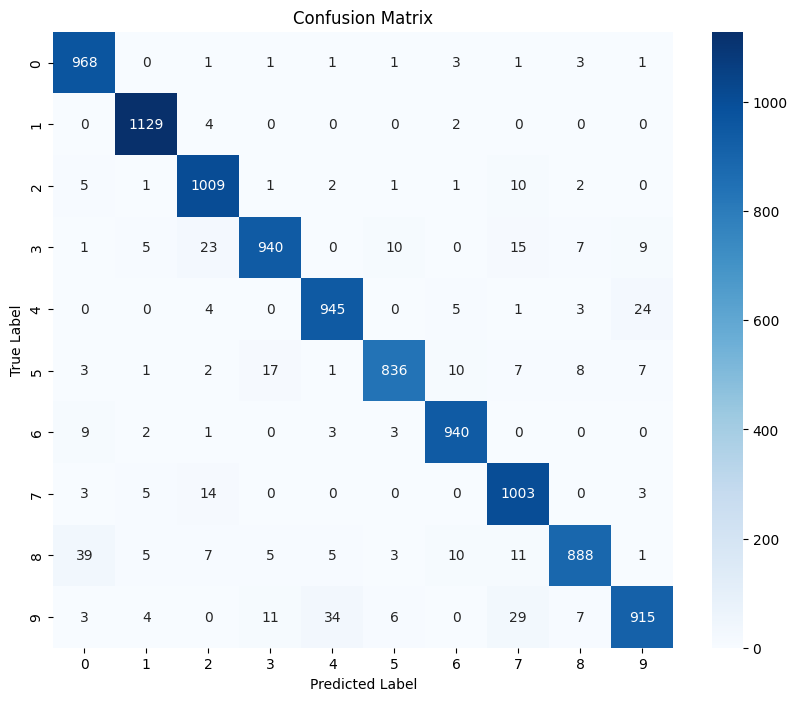

Accuracy: 0.9573, F1 Score: 0.9571, Cohen's Kappa: 0.9525


In [12]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='weighted')
    kappa = cohen_kappa_score(all_targets, all_preds)
    
    # Print classification report
    print(classification_report(all_targets, all_preds))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy, f1, kappa

# Usage
model.load_state_dict(best_weights)
accuracy, f1, kappa = evaluate_model(model, test_loader, device)
print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Cohen\'s Kappa: {kappa:.4f}')
